In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import xpart as xp
import xtrack as xt

fname_model = './generate_models/lhc_at_injection_obstacle.json'

collider = xt.Multiline.from_json(fname_model)
collider.build_trackers()

nemitt_x = 3.5e-6
nemitt_y = 3.5e-6
num_particles = 1000

/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:95: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Loading line from dict:   0%|          | 0/23767 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23688 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23684 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/23688 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


## Investigating an obstacle

We start by twissing. We need to build a bunch of particles. Since we will reuse the bunch later, we copy it as a template.

In [2]:
bunch = xp.generate_matched_gaussian_bunch(
    line=collider.lhcb1,
    sigma_z=10e-2,
    nemitt_x=nemitt_x,
    nemitt_y=nemitt_y,
    num_particles=num_particles,
)
bunch_template = bunch.copy()

tw = collider.lhcb1.twiss()
sigmas = tw.get_betatron_sigmas(nemitt_x=nemitt_x, nemitt_y=nemitt_y)

*** Maximum RMS bunch length 0.11789516327996152m.
... distance to target bunch length: -1.0000e-01
... distance to target bunch length: 1.4638e-02
... distance to target bunch length: 1.3573e-02
... distance to target bunch length: -1.0721e-03
... distance to target bunch length: 1.6142e-03
... distance to target bunch length: 7.1106e-05
... distance to target bunch length: 2.9063e-06
... distance to target bunch length: -4.0653e-10
... distance to target bunch length: 1.9477e-07
--> Bunch length: 0.09999999959346687
--> Emittance: 0.6422094474317409


Text(0.5, 0.98, "$q_x$ = 62.31000 $q_y$ = 60.32000\n$Q'_x$ = 1.95 $Q'_y$ = 2.03 $\\gamma_{tr}$ = 53.65")

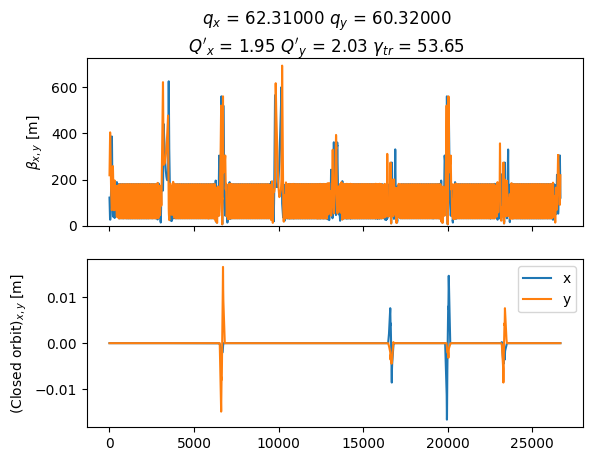

In [3]:
fig, (spbet, spco) = plt.subplots(nrows=2, ncols=1, sharex=True)
spbet.plot(tw['s'], tw['betx'])
spbet.plot(tw['s'], tw['bety'])
spbet.set_ylim(bottom=0)
spco.plot(tw['s'], tw['x'], label='x')
spco.plot(tw['s'], tw['y'], label='y')
spco.legend()
spbet.set_ylabel(r'$\beta_{x,y}$ [m]')
spco.set_ylabel(r'(Closed orbit)$_{x,y}$ [m]')

fig.suptitle(
    r'$q_x$ = ' f'{tw["qx"]:.5f}' r' $q_y$ = ' f'{tw["qy"]:.5f}' '\n'
    r"$Q'_x$ = " f'{tw["dqx"]:.2f}' r" $Q'_y$ = " f'{tw["dqy"]:.2f}'
    r' $\gamma_{tr}$ = '  f'{1/np.sqrt(tw["momentum_compaction_factor"]):.2f}'
)

### Track the bunch

We track the bunch and observe the losses:

In [4]:
collider.lhcb1.track(bunch, num_turns=5)
print(f'Lost beam fraction: {np.sum(bunch.state <= 0)/num_particles*100:.2f}%')

Lost beam fraction: 24.30%


To find out where we lose the particles, we filter them, and inspect the element where the losses occur:

In [5]:
lost_particles = bunch.filter(bunch.state <= 0)

# Find the name of the element where we lose most particles
from collections import Counter
i_most_losses = Counter(lost_particles.at_element).most_common(1)[0][0]

print(f'The element where we lose most particles is called `{collider.lhcb1.element_names[i_most_losses]}`.')

The element where we lose most particles is called `obstacle`.


### Plot the lost particles at the obstacle

The element where we lose the particles is of an aperture type:

In [6]:
collider.lhcb1.elements[i_most_losses]

LimitPolygon(x_vertices=[ 0.022       0.02182652  0.02130883  0.02045508  0.01927875  0.01779837
  0.01603731  0.01402333  0.01178819  0.00936714  0.00679837  0.00412239
  0.00138139 -0.00138139 -0.00412239 -0.00679837 -0.00936714 -0.01178819
 -0.01402333 -0.01603731 -0.01779837 -0.01927875 -0.02045508 -0.02130883
 -0.02182652 -0.022      -0.02182652 -0.02130883 -0.02045508 -0.01927875
 -0.01779837 -0.01603731 -0.01402333 -0.01178819 -0.00936714 -0.007
  0.          0.01        0.02045508  0.02130883  0.02182652  0.022     ], y_vertices=[ 0.00000000e+00  2.75733114e-03  5.47117752e-03  8.09874016e-03
  1.05985808e-02  1.29312756e-02  1.50600363e-02  1.69512913e-02
  1.80000000e-02  1.80000000e-02  1.80000000e-02  1.80000000e-02
  1.80000000e-02  1.80000000e-02  1.80000000e-02  1.80000000e-02
  1.80000000e-02  1.80000000e-02  1.69512913e-02  1.50600363e-02
  1.29312756e-02  1.05985808e-02  8.09874016e-03  5.47117752e-03
  2.75733114e-03 -7.07582864e-18 -2.75733114e-03 -5.47117752e-03
 -

We can plot the lost particles and the obstacle cross-section:

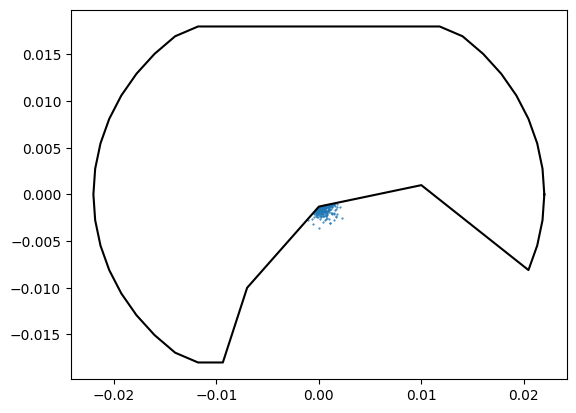

In [7]:
# Plot the lost particles and the obstacle
obstacle = collider.lhcb1['obstacle']
fig2 = plt.figure(2)
plt.plot(lost_particles.x, lost_particles.y, '.', markersize=1)
plt.plot(obstacle.x_vertices, obstacle.y_vertices, 'k')

### Correct the orbit to avoid the obstacle

Find an element close to the obstacle:

In [8]:
s_obstacle = tw['s', 'obstacle']
tw.rows[s_obstacle-5.:s_obstacle+5.:'s']

TwissTable: 8 rows, 41 cols
name                               s           x           px            y          py ...
mb.c15r8.b1..1               17296.5 1.68121e-06 -2.16691e-08 -2.04115e-07 -3.1632e-09
drift_7471                   17296.5 1.68121e-06 -1.82169e-08 -2.04115e-07 -3.1632e-09
obstacle                     17301.2 1.59437e-06 -1.82169e-08 -2.19193e-07 -3.1632e-09
chamber                      17301.2 1.59437e-06 -1.82169e-08 -2.19193e-07 -3.1632e-09
mb.c15r8.b1                  17301.2 1.59437e-06 -1.82169e-08 -2.19193e-07 -3.1632e-09
drift_7472                   17301.2 1.59437e-06 -1.82169e-08 -2.19193e-07 -3.1632e-09
mb.c15r8.b1..2                 17306 1.50754e-06 -1.82169e-08  -2.3427e-07 -3.1632e-09
drift_7473                     17306 1.50754e-06 -1.47647e-08  -2.3427e-07 -3.1632e-09

In [9]:
element_close_to_obstacle = 'mb.c15r8.b1'

Find the vertical correctors close to the obstacle:

In [10]:
tw.rows[s_obstacle-300.:s_obstacle+300.:'s', 'obstacle|mcbv.*']

TwissTable: 6 rows, 41 cols
name                               s           x           px            y           py ...
mcbv.11r8.b1                   17101 1.63309e-06  1.15161e-08  2.39107e-07 -3.48957e-09
mcbv.13r8.b1                 17207.9 1.32796e-06  1.71837e-08 -4.27231e-08 -8.33154e-10
obstacle                     17301.2 1.59437e-06 -1.82169e-08 -2.19193e-07  -3.1632e-09
mcbv.15r8.b1                 17314.8   1.474e-06  2.39467e-08 -2.45224e-07  3.60209e-09
mcbv.17r8.b1                 17421.7 1.62308e-06  2.18696e-08   4.2666e-08  8.33992e-10
mcbv.19r8.b1                 17528.6 1.47708e-06   1.5106e-08  2.45234e-07 -3.60189e-09

Find out the knob that controls the corrector:

In [11]:
v_corr = 'mcbv.15r8.b1'
collider.lhcb1.element_refs[v_corr].ksl[0]._expr

vars['acbv15.r8b1']

Perform a match to move the beam vertically at the obstacle:

In [12]:
collider.lhcb1_co_ref.match(
    method='4d',
    ele_start='bpm.10r8.b1',
    ele_stop='bpm.18r8.b1',
    twiss_init=tw.get_twiss_init(at_element='bpm.10r8.b1'),
    vary=[
        xt.Vary(name='acbv11.r8b1', step=1e-10),
        xt.Vary(name='acbv13.r8b1', step=1e-10),
        xt.Vary(name='acbv15.r8b1', step=1e-10),
        xt.Vary(name='acbv17.r8b1', step=1e-10),
    ],
    targets=[
        # I want the vertical orbit to be at 10 mm from obstacle with flat angle
        xt.Target('y', at=element_close_to_obstacle, value=10e-3, tol=1e-4, scale=1),
        xt.Target('py', at=element_close_to_obstacle, value=0, tol=1e-6, scale=1000),
        # I want the bump to be closed
        xt.Target('y', at='bpm.18r8.b1', value=tw['y', 'bpm.18r8.b1'],
                  tol=1e-6, scale=1),
        xt.Target('py', at='bpm.18r8.b1', value=tw['py', 'bpm.18r8.b1'],
                   tol=1e-7, scale=1000),
    ]
)

Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
Matching: model call n. 12       



However, we observe that after matching, if we track, all particles are lost!

In [13]:
bunch = bunch_template.copy()
collider.lhcb1.track(bunch, num_turns=5)
print(f'Lost beam fraction: {np.sum(bunch.state <= 0)/num_particles*100:.2f}%')

Lost beam fraction: 100.00%


Why is that? We need to match less aggressively.

In [14]:
collider.lhcb1_co_ref.match(
    method='4d',
    ele_start='bpm.10r8.b1',
    ele_stop='bpm.18r8.b1',
    twiss_init=tw.get_twiss_init(at_element='bpm.10r8.b1'),
    vary=[
        xt.Vary(name='acbv11.r8b1', step=1e-10),
        xt.Vary(name='acbv13.r8b1', step=1e-10),
        xt.Vary(name='acbv15.r8b1', step=1e-10),
        xt.Vary(name='acbv17.r8b1', step=1e-10),
    ],
    targets=[
        # I want the vertical orbit to be at 1 mm from obstacle with flat angle
        xt.Target('y', at=element_close_to_obstacle, value=1.5e-3, tol=1e-4, scale=1),
        xt.Target('py', at=element_close_to_obstacle, value=0, tol=1e-6, scale=1000),
        # I want the bump to be closed
        xt.Target('y', at='bpm.18r8.b1', value=tw['y', 'bpm.18r8.b1'],
                  tol=1e-6, scale=1),
        xt.Target('py', at='bpm.18r8.b1', value=tw['py', 'bpm.18r8.b1'],
                   tol=1e-7, scale=1000),
    ]
)

Matching: model call n. 12       



In [15]:
bunch = bunch_template.copy()
collider.lhcb1.track(bunch, num_turns=5)
print(f'Lost beam fraction: {np.sum(bunch.state <= 0)/num_particles*100:.2f}%')

Lost beam fraction: 0.90%


There are still some losses, we can plot the beam at the obstacle, to see what happens. To do that, we need to insert a monitor at the obstacle:

In [16]:
collider.lhcb1.discard_tracker()
monitor_obstacle = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=4,
                                       num_particles=num_particles)
collider.lhcb1.insert_element(
    index='obstacle',
    element=monitor_obstacle,
    name='monitor_obstacle',
)
collider.lhcb1.build_tracker()
bunch = bunch_template.copy()
collider.lhcb1.track(bunch, num_turns=5)

Found suitable prebuilt kernel `default_only_xtrack`.


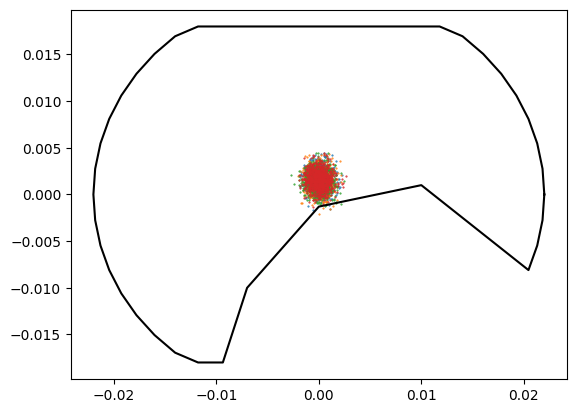

In [17]:
obstacle = collider.lhcb1['obstacle']
fig, ax = plt.subplots()
ax.plot(monitor_obstacle.x, monitor_obstacle.y, '.', markersize=1)
ax.plot(obstacle.x_vertices, obstacle.y_vertices, 'k')

Some particles are still lost at the obstacle. We can shift the beam a little horizontaly to fix this issue completely. As before, we find the knob that controls the horizontal corrector close to the beam.

In [18]:
tw.rows[s_obstacle-300.:s_obstacle+300.:'s', 'mcbh.*|obstacle']

TwissTable: 6 rows, 41 cols
name                               s           x           px            y           py ...
mcbh.12r8.b1                 17154.4 2.68505e-06  -3.8315e-08  5.64296e-08 -1.90379e-09
mcbh.14r8.b1                 17261.3 2.66895e-06 -3.54758e-08 -9.29943e-08  -3.1632e-09
obstacle                     17301.2 1.59437e-06 -1.82169e-08 -2.19193e-07  -3.1632e-09
mcbh.16r8.b1                 17368.2 3.14394e-06 -4.17711e-08  -5.6977e-08   1.9138e-09
mcbh.18r8.b1                 17475.1 3.17905e-06 -4.49976e-08   9.2981e-08  3.16365e-09
mcbh.20r8.b1                   17582 2.70406e-06 -3.87031e-08  5.69987e-08 -1.91306e-09

In [19]:
h_corr = 'mcbh.14r8.b1'
collider.lhcb1.element_refs[h_corr].knl[0]._expr

(-vars['acbh14.r8b1'])

Match again:

In [20]:
collider.lhcb1_co_ref.match(
    method='4d',
    ele_start='bpm.10r8.b1',
    ele_stop='bpm.20r8.b1',
    twiss_init=tw.get_twiss_init(at_element='bpm.10r8.b1'),
    vary=[
        xt.Vary(name='acbh12.r8b1', step=1e-10),
        xt.Vary(name='acbh14.r8b1', step=1e-10),
        xt.Vary(name='acbh16.r8b1', step=1e-10),
        xt.Vary(name='acbh18.r8b1', step=1e-10),
    ],
    targets=[
        # I want the vertical orbit to be at 1 mm from obstacle with flat angle
        xt.Target('x', at=element_close_to_obstacle, value=-3e-3, tol=1e-4, scale=1),
        xt.Target('px', at=element_close_to_obstacle, value=0, tol=1e-6, scale=1000),
        # I want the bump to be closed
        xt.Target('x', at='bpm.20r8.b1', value=tw['x', 'bpm.20r8.b1'],
                  tol=1e-6, scale=1),
        xt.Target('px', at='bpm.20r8.b1', value=tw['px', 'bpm.20r8.b1'],
                   tol=1e-7, scale=1000),
    ]
)

Matching: model call n. 12       



Track and inspect the beam again, this time there should be no losses:

Lost beam fraction: 0.00%


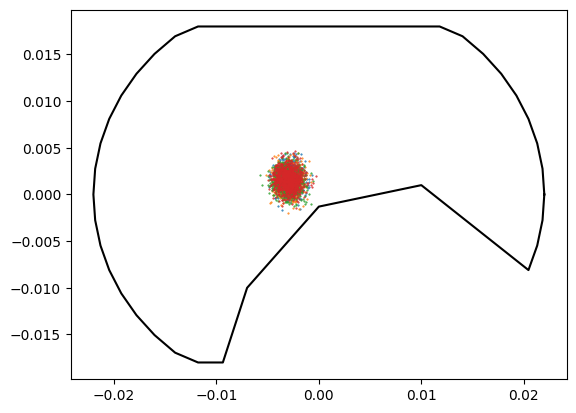

In [21]:
bunch = bunch_template.copy()
collider.lhcb1.track(bunch, num_turns=5)

# See the beam at the obstacle:
obstacle = collider.lhcb1['obstacle']
fig, ax = plt.subplots()
ax.plot(monitor_obstacle.x, monitor_obstacle.y, '.', markersize=1)
ax.plot(obstacle.x_vertices, obstacle.y_vertices, 'k')

# We don't lose so many particles anymore
print(f'Lost beam fraction: {np.sum(bunch.state <= 0)/num_particles*100:.2f}%')